In [1]:
!adb exec-out run-as si.fri.matevzfa.approxhpvmdemo cat "databases/classification-log" > classification-log.sqlite3

In [13]:
import sqlite3
import pandas as pd
import ipywidgets as widgets

con = sqlite3.connect("classification-log.sqlite3")

df_full = pd.read_sql_query("SELECT * FROM classification", con)
df_full["timestamp"] = pd.to_datetime(df_full["timestamp"], infer_datetime_format=True)
df_full["run_start"] = pd.to_datetime(df_full["run_start"], infer_datetime_format=True)

df_full["run_start"].unique()


starts = df_full["run_start"].sort_values(ascending=False).unique()
mapped = [s.strftime("%a %-d %b %Y %H:%M:%S") for s in starts]

w = widgets.Select(
    options=list(zip(mapped, starts)),
    description="Select run",
)
w

Select(description='Select run', options=(('Tue 31 Aug 2021 16:36:29', Timestamp('2021-08-31 16:36:29.409000+0…

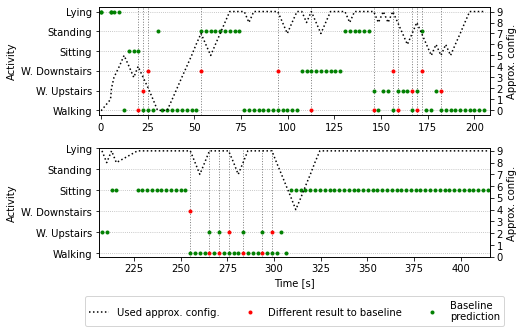

missing: 0


In [18]:
import matplotlib.pyplot as plt
import numpy as np

labels = [
    "Walking",
    "W. Upstairs",
    "W. Downstairs",
    "Sitting",
    "Standing",
    "Lying",
]

df = df_full[df_full["run_start"] == w.value].copy()
df["timestamp"] = (df["timestamp"] - df["timestamp"].min()) / pd.to_timedelta(1, unit='s')
engine = df.used_engine.unique()[0]

perrow_cca = 100
nrows = int(np.ceil(len(df) / perrow_cca))

perrow_seconds = df.timestamp.max() / nrows

fig, axs = plt.subplots(nrows=nrows, figsize=(7, nrows*2.3))
plt.subplots_adjust(hspace=0.3)

plotted = 0

for i, ax1 in enumerate(axs):

    ts_min = i*perrow_seconds
    ts_max = (i+1)*perrow_seconds

    df_sub = df.loc[(ts_min <= df.timestamp) & (df.timestamp <= ts_max), :]

    plotted += len(df_sub)

    ax2 = ax1.twinx()

    ln_conf = ax2.plot(df_sub.timestamp, df_sub.used_config, 'k:', label="Used approx. config.")
    ax2.set_yticks(list(range(10)))
    ax2.set_yticklabels(list(range(10)))

    wrong = df_sub[df_sub.argmax != df_sub.argmax_baseline]

    for ts in wrong.timestamp:
        ax1.axvline(ts, c='gray', ls=':', lw=1)

    ax1.grid(ls=':', axis='y')
    ln_r = ax1.plot(wrong.timestamp, wrong.argmax, 'r.', label="Different result to baseline")
    ln_g = ax1.plot(df_sub.timestamp, df_sub.argmax_baseline, 'g.', label="Baseline\nprediction")
    ax1.set_yticks(list(range(len(labels))))
    ax1.set_yticklabels(labels)

    ax1.set_xlim(ts_min-1, ts_max+1)

    ax1.set_ylabel("Activity")
    ax2.set_ylabel("Approx. config.")

lns = ln_conf + ln_r + ln_g
axs[-1].legend(lns, [l.get_label() for l in lns],
               loc="center", bbox_to_anchor=[0.5, -0.5], ncol=3)

axs[-1].set_xlabel("Time [s]")

fig.savefig(f"adaptation-{engine}-{str(w.value).replace(' ', '-')}.pdf", bbox_inches='tight')
plt.show()

print(f"missing: {plotted - len(df)}")


In [15]:
df

,uid,timestamp,run_start,used_config,argmax,argmax_baseline,confidence_concat,confidence_baseline_concat,signal_image,used_engine
496,497,0.000,2021-08-31 16:36:29.409000+02:00,0,3,3,"3.5606593E-7,2.245758E-6,4.639759E-6,0.9999879...","3.5606593E-7,2.245758E-6,4.639759E-6,0.9999879...","0.43803942,0.9811733,0.82109976,0.7773352,0.90...",KalmanAdaptation
497,498,3.671,2021-08-31 16:36:29.409000+02:00,1,3,3,"5.4459062E-5,2.6159178E-4,9.3766855E-4,0.99834...","4.4265227E-7,2.6505365E-6,6.441833E-6,0.999985...","-0.07283777,-0.08371413,-0.08086985,-0.0763146...",KalmanAdaptation
498,499,4.150,2021-08-31 16:36:29.409000+02:00,3,3,3,"0.0018600333,0.02193496,0.009592759,0.9557549,...","4.440996E-7,2.6337275E-6,6.4136843E-6,0.999985...","0.0052161813,0.0032718182,0.003488481,0.002190...",KalmanAdaptation
499,500,4.580,2021-08-31 16:36:29.409000+02:00,7,3,3,"8.9938246E-4,0.004549634,0.04703934,0.9247283,...","4.6960022E-7,2.7689287E-6,6.891242E-6,0.999984...","0.0036872625,0.0042974353,0.0040482283,0.00493...",KalmanAdaptation
500,501,7.014,2021-08-31 16:36:29.409000+02:00,9,3,3,"0.0024532017,0.00965099,0.22808796,0.7110021,0...","4.4589856E-7,2.63426E-6,6.4466885E-6,0.9999851...","-0.0040429235,-0.0068870187,-0.0061843395,-0.0...",KalmanAdaptation
...,...,...,...,...,...,...,...,...,...,...
600,601,273.177,2021-08-31 16:36:29.409000+02:00,0,0,0,"0.9999994,1.4939393E-7,1.4570627E-7,2.4014426E...","0.9999994,1.4939393E-7,1.4570627E-7,2.4014426E...","-0.052985072,-0.06822449,-0.06356591,-0.044172...",KalmanAdaptation
601,602,275.872,2021-08-31 16:36:29.409000+02:00,1,3,3,"1.0730886E-4,3.9482614E-4,0.0018325234,0.99692...","5.2579026E-7,3.0731308E-6,7.223762E-6,0.999982...","-0.0019900203,-0.04855472,-0.036371112,-0.0046...",KalmanAdaptation
602,603,278.167,2021-08-31 16:36:29.409000+02:00,0,3,3,"4.8059405E-7,3.097362E-6,7.488975E-6,0.9999825...","4.8059405E-7,3.097362E-6,7.488975E-6,0.9999825...","-0.05986792,-0.06670225,-0.06555349,-0.0639601...",KalmanAdaptation
603,604,280.770,2021-08-31 16:36:29.409000+02:00,1,3,3,"6.816418E-5,3.084886E-4,0.0010118657,0.9982072...","3.8387222E-7,2.6993603E-6,5.615208E-6,0.999985...","0.0021167397,-0.0010173321,9.894371E-5,1.03890...",KalmanAdaptation
